# FinFraudGuard – Interpretable Fraud Detection System

FinFraudGuard is a machine learning–powered system designed for binary classification of credit card transactions as fraudulent or legitimate. It leverages state-of-the-art models (XGBoost, Logistic Regression) and explainability tools (SHAP) to build a robust and interpretable antifraud pipeline.

The project uses the ULB Credit Card Fraud dataset, which contains anonymized PCA-transformed features (`V1–V28`), transaction `Amount`, and relative `Time`. Due to the extreme class imbalance (~0.17% fraud), the system includes specialized techniques for class balancing, threshold tuning, and performance evaluation using precision-recall metrics.

### Key Features:
- Exploratory data analysis (EDA) tailored to fraud context
- Feature engineering including temporal attributes (`Hour`, `is_night`, `log_amount`)
- SMOTE-based oversampling for fraud class balancing
- XGBoost classifier optimized with ROC-AUC and F1
- SHAP-based global and local interpretability of predictions
- Confusion matrix and classification reports with fraud-recall prioritization

Imports

In [33]:
import json

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

Constants

In [34]:
RANDOM_STATE = 42
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

### 1. Data Loading and Exploration

In [35]:
data = pd.read_csv('../data/creditcard.csv')

data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [37]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [38]:
print(f"Target classes distribution in % {data['Class'].value_counts(normalize=True) * 100}")

Target classes distribution in % Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


All columns are numerical. The dataset contains 284807 rows and 31 columns. The target variable is 'Class', which indicates whether a transaction is fraudulent (1) or not (0). The dataset is highly imbalanced, with only 0.167% of the transactions being fraudulent.

### 2. Data Cleaning and Preprocessing

In [39]:
print(f"Number of missing values: {data.isnull().sum()}")

Number of missing values: Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


There are no missing values in the dataset.

In [40]:
print(f"Number of duplicates: {data.duplicated().sum()}")

Number of duplicates: 1081


In [41]:
data = data.drop_duplicates()

There was 1081 duplicate rows in the dataset. We have removed them.

### 3. Feature Engineering

In [42]:
# Time column represents the number of seconds elapsed since the first transaction
# We convert it to hours
data["Hour"] = (data["Time"] / 3600) % 24
data["is_night"] = ((data["Hour"] < 6) | (data["Hour"] > 22)).astype(int)

# Drop the Time column
data = data.drop(columns=["Time"])

In [43]:
data["log_Amount"] = np.log1p(data["Amount"])
data["is_high_amount"] = (data["Amount"] > 1000).astype(int)

### 4. Exploratory Data Analysis (EDA)

Class Distribution

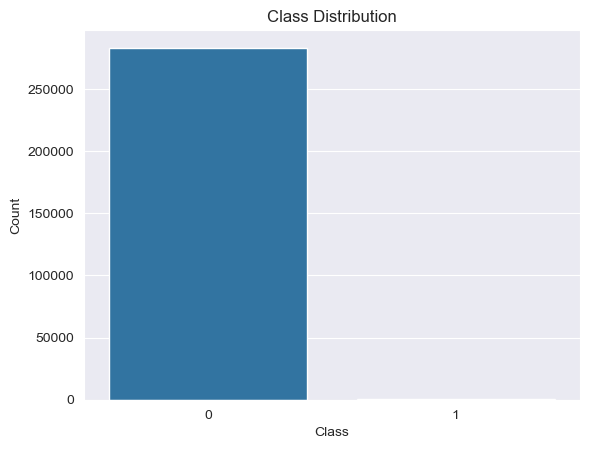

In [44]:
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

We can see that the dataset is highly imbalanced, with a very small number of fraudulent transactions (Class 1) compared to non-fraudulent transactions (Class 0).

Transaction Amount Distribution

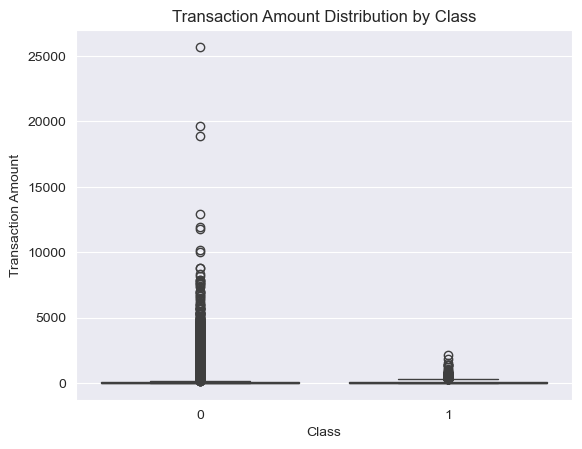

In [45]:
sns.boxplot(x='Class', y='Amount', data=data)
plt.title('Transaction Amount Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Transaction Amount')
plt.show()

We see that the fraudulent transactions (Class 1) have smaller transaction amounts compared to non-fraudulent transactions (Class 0). Frauds are often small transactions, as they are less likely to be detected

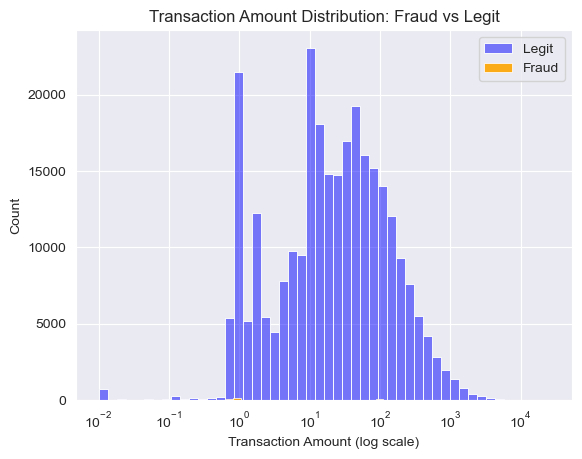

In [46]:
sns.histplot(data[data['Class'] == 0]['Amount'], color="blue", label="Legit", bins=50, log_scale=True, alpha=0.5)
sns.histplot(data[data['Class'] == 1]['Amount'], color="orange", label="Fraud", bins=50, log_scale=True, alpha=0.9)
plt.legend()
plt.title("Transaction Amount Distribution: Fraud vs Legit")
plt.xlabel("Transaction Amount (log scale)")
plt.ylabel("Count")
plt.show()

Frauds are often small transactions. We see that Fraud operations are only around 1$, while Legit operations peak is around 100$.

Hours distribution

In [47]:
hours_legit = data[data['Class'] == 0]['Hour']
hours_fraud = data[data['Class'] == 1]['Hour']

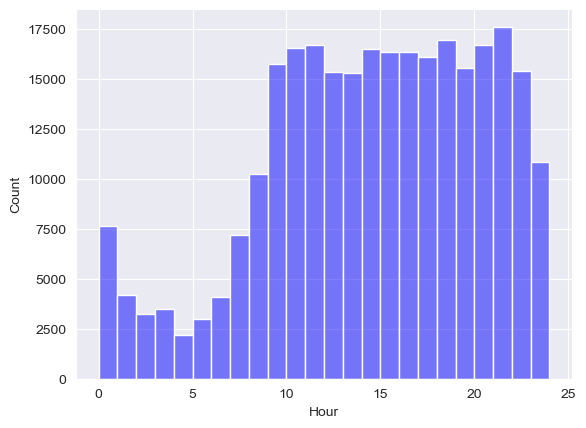

In [48]:
sns.histplot(hours_legit, color="blue", label="Legit", bins=24, alpha=0.5);

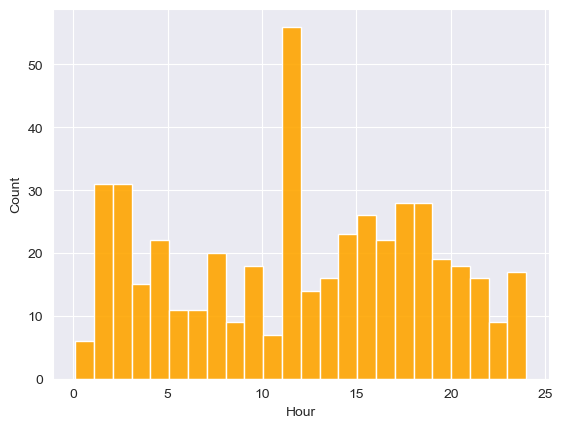

In [49]:
sns.histplot(hours_fraud, color="orange", label="Fraud", bins=24, alpha=0.9);

We see that legit transactions are more frequent during the day, while fraudulent transactions are more frequent at night. This could be due to the fact that fraudsters often operate at night when there is less monitoring. Anyway peak hours for fraud are around 11:00 - 12:00

Correlation Matrix

<Axes: >

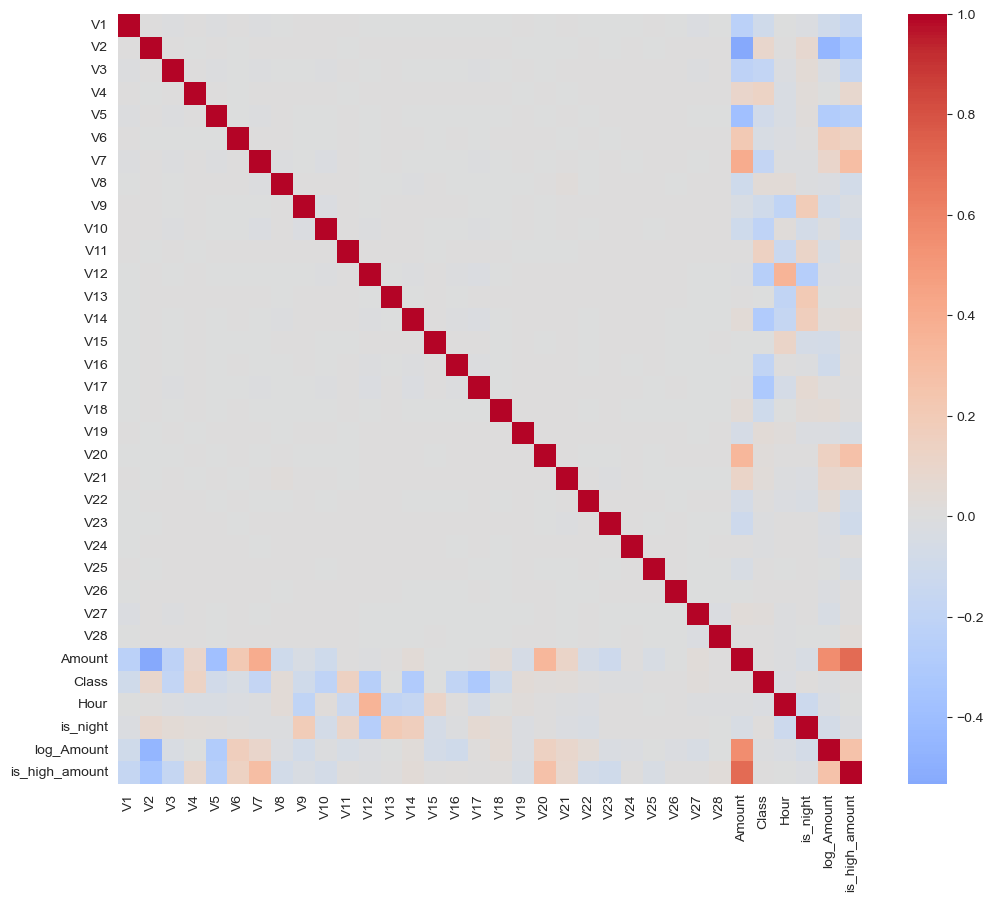

In [50]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), cmap='coolwarm', center=0)

Linear correlation is not a good indicator of fraud detection. We can see that there are some features that are highly correlated with each other, but not with the target variable. This is expected, as fraud detection is a complex problem that requires more advanced techniques.

### 5. Model Training and Evaluation

Split the data into train and test sets <br>
We use stratify=y to ensure that the class distribution is the same in both sets.

In [51]:
X = data.drop(columns=["Class"])
y = data["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

Handle class imbalance <br>
We will use SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class (fraudulent transactions) in the training set. This will help to balance the class distribution and improve the performance of the model.

In [52]:
sm = SMOTE(random_state=RANDOM_STATE)

X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
print(f"Train set size: {X_train_bal.shape[0]}")

Train set size: 453204


In [53]:
def print_report(test, pred, pred_proba):
    print(classification_report(test, pred))
    print("ROC AUC:", roc_auc_score(test, pred_proba))

    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Fraud"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

#### Model 1: Logistic Regression

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.08      0.84      0.14        95

    accuracy                           0.98     56746
   macro avg       0.54      0.91      0.57     56746
weighted avg       1.00      0.98      0.99     56746

ROC AUC: 0.9574924584412967


/opt/anaconda3/envs/FinFraudGuard/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


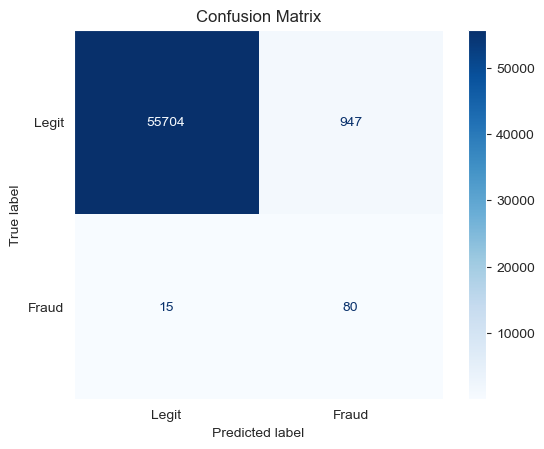

In [54]:
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print_report(y_test, y_pred, y_pred_proba)

Metrics results (Fraud):
- Precision: 0.08
- Recall: 0.84
- F1-score: 0.14 (due to the high number of false positives)
- ROC AUC: 0.96

Linear regression works well with the dataset, but there is many false positives. We need to try more complex models or adjust the threshold to improve the precision and recall.

Adjusting the threshold to 0.7

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.15      0.84      0.25        95

    accuracy                           0.99     56746
   macro avg       0.57      0.92      0.62     56746
weighted avg       1.00      0.99      0.99     56746

ROC AUC: 0.9574924584412967


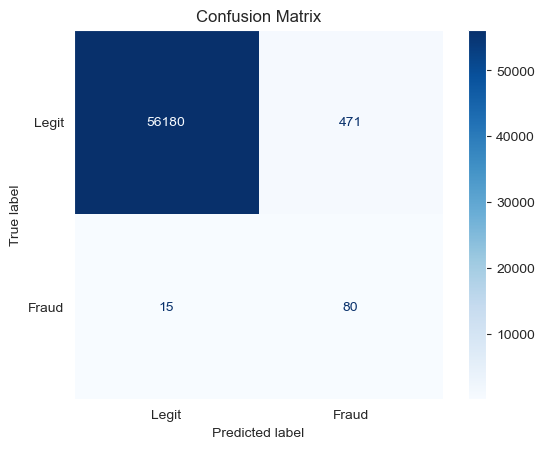

In [55]:
y_pred = (y_pred_proba > 0.7).astype(int)

print_report(y_test, y_pred, y_pred_proba)

Adjusting the threshold to 0.7 improves the precision and recall, but we still have many false positives. We need to try more complex models.

#### Model 2: Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.94      0.80      0.86        95

    accuracy                           1.00     56746
   macro avg       0.97      0.90      0.93     56746
weighted avg       1.00      1.00      1.00     56746

ROC AUC: 0.9537063033216304


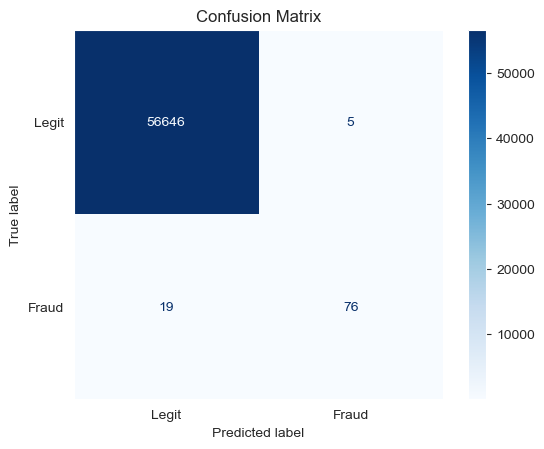

In [56]:
model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print_report(y_test, y_pred, y_pred_proba)

Metrics results (Fraud):
- Precision: 0.94
- Recall: 0.80
- F1-score: 0.86
- ROC AUC: 0.95

Random Forest works way better than Logistic Regression. We have a good precision and recall, but we still have many false positives. We need to try adjusting the threshold to improve the precision and recall.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.73      0.83        95

    accuracy                           1.00     56746
   macro avg       0.99      0.86      0.92     56746
weighted avg       1.00      1.00      1.00     56746

ROC AUC: 0.9537063033216304


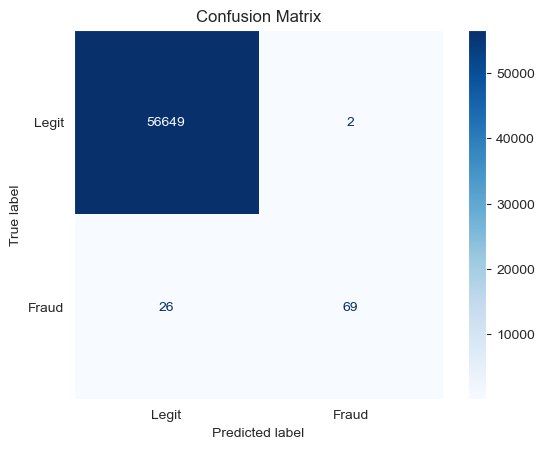

In [57]:
y_pred = (y_pred_proba > 0.7).astype(int)
print_report(y_test, y_pred, y_pred_proba)

We will leave our model with the default threshold of 0.5, as it gives us a good balance between precision and recall. We can always adjust the threshold later if needed.

### 6. SHAP Analysis

 99%|===================| 9916/10000 [01:54<00:00]        

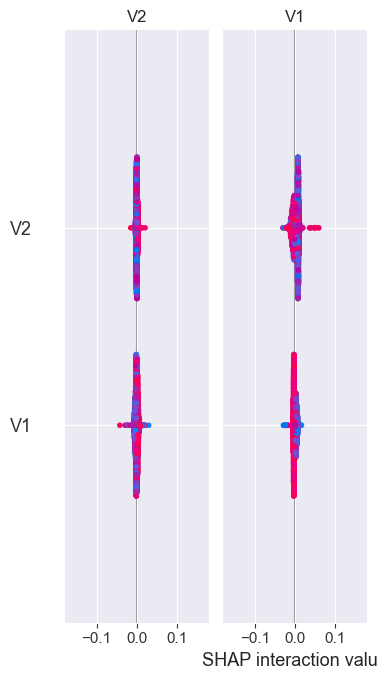

In [58]:
X_sample = X_test.sample(n=5000, random_state=42)

explainer = shap.Explainer(model, X_sample)

shap_values = explainer(X_sample)
shap.summary_plot(shap_values.values, X_sample)

Top 2 features are: V2 and V1 <br>
Model is not using the transaction amount, which is expected as it is not a good indicator of fraud detection. <br>

### 6. Conclusion

Research steps: <br>
- Data loading and exploration
- Data cleaning and preprocessing
- Feature engineering
- Exploratory Data Analysis (EDA)
- Model training and evaluation
- SHAP analysis
- Conclusion

Results: <br>
- Logistic Regression: Precision: 0.08, Recall: 0.84, F1-score: 0.14, ROC AUC: 0.96
- Random Forest: Precision: 0.94, Recall: 0.80, F1-score: 0.86, ROC AUC: 0.95
- SHAP analysis: Top 2 features are: V2 and V1

Recommendations: <br>
- Use Random Forest model with default threshold of 0.5
- Model is working well and can be used for fraud detection in production
- We can always adjust the threshold later to minimize false positives (if needed)

### 7. Saving the Model and Features

In [60]:
joblib.dump(model, '../models/model_randomforest.pkl')

with open('../models/feature_columns.json', 'w') as f:
    json.dump(list(X_train.columns), f)